### CADERNO DE ANÁLISE EXPLORATÓRIA - MÓDULO 2 AULA 1

O bloco de código abaixo foi escrito para retornar ao ponto de paramos na última aula do módulo 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv("https://raw.githubusercontent.com/alura-cursos/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv",
                 encoding = "ISO-8859-1", skiprows = 3, sep=";", skipfooter=12, thousands = ".", decimal = ",",
                 engine="python")

colunas_usaveis = df.mean().index.tolist()
colunas_usaveis.insert(0, "Unidade da Federação")

usaveis = df[colunas_usaveis]
usaveis = usaveis.set_index("Unidade da Federação")
UFS = usaveis.index.tolist()
codigos = [uf[0:2] for uf in UFS]
regioes = []

for i in range(len(codigos)):
    if codigos[i][0] == '1':
        regioes.append("Norte")
    if codigos[i][0] == '2':
        regioes.append("Nordeste")
    if codigos[i][0] == '3':
        regioes.append("Sudeste")
    if codigos[i][0] == '4':
        regioes.append("Sul")
    if codigos[i][0] == '5':
        regioes.append("Centro-Oeste")
usaveis.insert(loc=0, column="Região", value=regioes)

usaveis_ord_total = usaveis.sort_values("Total", ascending = False)
usaveis_ord_total = usaveis_ord_total.drop("Total", axis = 1)
usaveis =  usaveis.drop("Total", axis = 1)

pd.options.display.float_format = "{:.2f}".format

ultimo_mes_valido = usaveis_ord_total[usaveis_ord_total.columns[-2]]

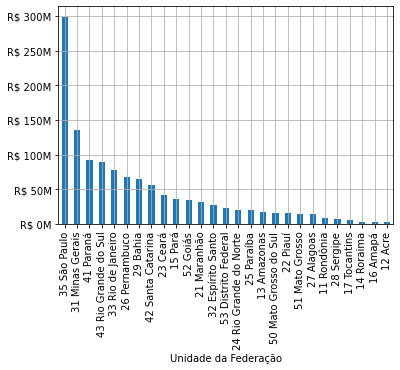

In [2]:
def millions(x, pos):
    return f'R$ {int(x/1000000)}M'

ultimo_mes_valido = ultimo_mes_valido.sort_values(ascending = False)

ax = ultimo_mes_valido.plot(kind='bar')

formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

plt.grid()
plt.show()

Como verificado na aula passada, valores absolutos eliminam a possibilidade de observar a relatividade dos dados. São Paulo tem o maior número de habitantes entre os estados brasileiros e o maior gasto com o SUS, mas será que é o que mais gasta per capita?

Vamos identificar qual é participação de cada UF no gasto total no último mês:

In [3]:
ultimo_mes_valido/ultimo_mes_valido.sum()

Unidade da Federação
35 São Paulo             0.24
31 Minas Gerais          0.11
41 Paraná                0.08
43 Rio Grande do Sul     0.07
33 Rio de Janeiro        0.06
26 Pernambuco            0.06
29 Bahia                 0.05
42 Santa Catarina        0.05
23 Ceará                 0.03
15 Pará                  0.03
52 Goiás                 0.03
21 Maranhão              0.03
32 Espírito Santo        0.02
53 Distrito Federal      0.02
24 Rio Grande do Norte   0.02
25 Paraíba               0.02
13 Amazonas              0.01
50 Mato Grosso do Sul    0.01
22 Piauí                 0.01
51 Mato Grosso           0.01
27 Alagoas               0.01
11 Rondônia              0.01
28 Sergipe               0.01
17 Tocantins             0.00
14 Roraima               0.00
16 Amapá                 0.00
12 Acre                  0.00
Name: 2020/Jun, dtype: float64

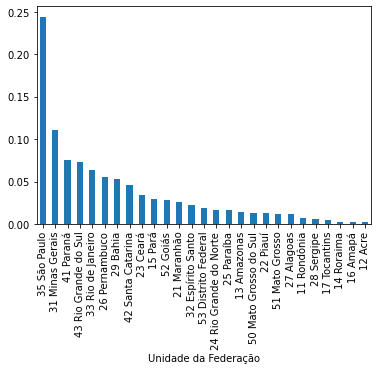

In [4]:
gastos_proporcionais = ultimo_mes_valido/ultimo_mes_valido.sum()
gastos_proporcionais.plot(kind='bar')

Devemos sempre pensar em formas de relativizar os dados... cidades e estados com maior número de pessoas idosas terão mais gasto com saúde que estados "jovens", épocas do ano - como nas festas do final - que acabam gerando mais gasto, etc. 

Vamos utilizar a base de dados sobre a população estimada pelo IBGE para poder aprofundar as análises.

In [5]:
# Fonte:  IBGE, IBGE (27 de agosto de 2020). «Estimativa Populacional 2020». ibge.gov.br. Consultado em 27 de novembro de 2020

ibge_est = pd.read_excel("https://github.com/alura-cursos/agendamento-hospitalar/raw/main/dados/estimativa_dou_2020.xls",
                         skiprows = 1, index_col = "BRASIL E UNIDADES DA FEDERAÇÃO", skipfooter=7)

ibge_est.pop("Unnamed: 1")
ibge_est

,POPULAÇÃO ESTIMADA
BRASIL E UNIDADES DA FEDERAÇÃO,
Brasil,211755692
Região Norte,18672591
Rondônia,1796460
Acre,894470
Amazonas,4207714
Roraima,631181
Pará,8690745
Amapá,861773
Tocantins,1590248


In [6]:
ibge_est.dtypes


POPULAÇÃO ESTIMADA    object
dtype: object

É possível verificar que alguns dados da coluna "população estimada" estão como string... para resolver isso, vamos remover os itens entre parenteses e normalizar os números (alguns possuem pontos para milhar e outros não)

In [7]:
# transformar todos os dados em string para não criar NaNs ao usar o str.replace
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].apply(lambda x: str(x))

# utilizar regex para remover números entre parenteses
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].str.replace("\(.\)","", regex=True)

# utilizar regex para remover pontos de milhar
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].str.replace("\.","", regex=True)

# transformar de volta pra int
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].apply(lambda x: int(x))

ibge_est

,POPULAÇÃO ESTIMADA
BRASIL E UNIDADES DA FEDERAÇÃO,
Brasil,211755692
Região Norte,18672591
Rondônia,1796460
Acre,894470
Amazonas,4207714
Roraima,631181
Pará,8690745
Amapá,861773
Tocantins,1590248


In [8]:
ibge_est.dtypes

POPULAÇÃO ESTIMADA    int64
dtype: object

### Desafio 01 - Entre nos dados do wikipedia e leia a Base de dados direto do wikipedia.

In [9]:
pagina = "https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o"

list_dfs_wiki = pd.read_html(pagina, attrs = {"class":"wikitable sortable"})

print(f"Foram importadas {len(list_dfs_wiki)} tables da Wikipedia")

Foram importadas 2 tables da Wikipedia


In [10]:
df_pop_regiao = list_dfs_wiki[1]
list_dfs_wiki[1]

,Posição,Região,População,% da pop. total,País comparável (habitantes)
0,1,Região Sudeste,89 012 240,"42,04%",República Democrática do Congo (86 790 567)
1,2,Região Nordeste,57 374 243,"27,09%",África do Sul (58 775 022)
2,3,Região Sul,30 192 315,"14,26%",Nepal (29 609 623)
3,4,Região Norte,18 672 591,"8,82%",Cazaquistão (18 574 680)
4,5,Região Centro-Oeste,16 504 303,"7,79%",Senegal (16 209 125)


In [11]:
df_pop_uf = list_dfs_wiki[0]
list_dfs_wiki[0]

,Posição,Unidade federativa,População,% da pop. total,País comparável (habitantes)
0,1,São Paulo,46 289 333,"21,9%",Espanha (46 439 864)
1,2,Minas Gerais,21 331 292,"10,1%",Sri Lanka (20 675 000)
2,3,Rio de Janeiro,17 366 189,"8,2%",Países Baixos (16 922 900)
3,4,Bahia,14 930 634,"7,1%",Chade (14 037 000)
4,5,Paraná,11 516 840,"5,4%",Bolívia (11 410 651)
5,6,Rio Grande do Sul,11 422 973,"5,4%",Bélgica (11 250 659)
6,7,Pernambuco,9 616 621,"4,5%",Bielorrússia (9 485 300)
7,8,Ceará,9 187 103,"4,3%",Emirados Árabes Unidos (9 157 000)
8,9,Pará,8 690 745,"4,1%",Áustria (8 602 112)
9,10,Santa Catarina,7 279 638,"3,4%",Sérvia (7 114 393)


### Desafio 02 - Neste desafio temos uma série de passos:


 * Padronizar os nomes das colunas
 * Transformar os dados nos tipos corretos
 * Transformar a UF em index

In [12]:
# Padronizando o nome das colunas

df_pop_uf.columns

Index(['Posição', 'Unidade federativa', 'População', '% da pop. total',
       'País comparável (habitantes)'],
      dtype='object')

In [13]:
df_pop_uf = df_pop_uf.rename(columns={'Posição':'index', 'Unidade federativa':'uf', 'População':"populacao",
                                      '% da pop. total':'part_pop_total','País comparável (habitantes)':'pais_approx_pop'})

df_pop_uf.head()

,index,uf,populacao,part_pop_total,pais_approx_pop
0,1,São Paulo,46 289 333,"21,9%",Espanha (46 439 864)
1,2,Minas Gerais,21 331 292,"10,1%",Sri Lanka (20 675 000)
2,3,Rio de Janeiro,17 366 189,"8,2%",Países Baixos (16 922 900)
3,4,Bahia,14 930 634,"7,1%",Chade (14 037 000)
4,5,Paraná,11 516 840,"5,4%",Bolívia (11 410 651)


In [14]:
# Transformando os dados nos tipos corretos

df_pop_uf.dtypes

index               int64
uf                 object
populacao          object
part_pop_total     object
pais_approx_pop    object
dtype: object

In [15]:
# Retirando os espaços na coluna população e trocando as vírgulas por pontos na part_pop_total
df_pop_uf.populacao = df_pop_uf.populacao.replace(" ", "", regex=True)
df_pop_uf.part_pop_total = df_pop_uf.part_pop_total.replace(",", ".", regex=True)

# Transformando a pop em int e a part_pop_total em float
df_pop_uf.part_pop_total = df_pop_uf.part_pop_total.apply(lambda x: float(x[:-1])/100)
df_pop_uf.populacao = df_pop_uf.populacao.apply(lambda x: int(x))

In [16]:
df_pop_uf.head(10)

,index,uf,populacao,part_pop_total,pais_approx_pop
0,1,São Paulo,46289333,0.22,Espanha (46 439 864)
1,2,Minas Gerais,21331292,0.10,Sri Lanka (20 675 000)
2,3,Rio de Janeiro,17366189,0.08,Países Baixos (16 922 900)
3,4,Bahia,14930634,0.07,Chade (14 037 000)
4,5,Paraná,11516840,0.05,Bolívia (11 410 651)
5,6,Rio Grande do Sul,11422973,0.05,Bélgica (11 250 659)
6,7,Pernambuco,9616621,0.04,Bielorrússia (9 485 300)
7,8,Ceará,9187103,0.04,Emirados Árabes Unidos (9 157 000)
8,9,Pará,8690745,0.04,Áustria (8 602 112)
9,10,Santa Catarina,7279638,0.03,Sérvia (7 114 393)


In [17]:
# Transformando a UF em index
df_pop_uf = df_pop_uf.set_index('uf')

In [18]:
df_pop_uf.pop('index')
df_pop_uf.pop('pais_approx_pop')
df_pop_uf.head(10)

,populacao,part_pop_total
uf,,
São Paulo,46289333,0.22
Minas Gerais,21331292,0.10
Rio de Janeiro,17366189,0.08
Bahia,14930634,0.07
Paraná,11516840,0.05
Rio Grande do Sul,11422973,0.05
Pernambuco,9616621,0.04
Ceará,9187103,0.04
Pará,8690745,0.04


### Aula 1, Video 2

Agora, está na hora de juntarmos os dois dataframes: a população de cada UF junto com os gastos do SUS no último mês.

In [19]:
ultimo_mes_valido.head(10)

Unidade da Federação
35 São Paulo           299060851.62
31 Minas Gerais        135977571.87
41 Paraná               92901461.36
43 Rio Grande do Sul    89019478.82
33 Rio de Janeiro       77604925.21
26 Pernambuco           68145110.59
29 Bahia                65159300.63
42 Santa Catarina       56503747.99
23 Ceará                42146555.81
15 Pará                 35396030.78
Name: 2020/Jun, dtype: float64

In [20]:
# Normalizando os nomes dos estados no index

ultimo_mes_valido = ultimo_mes_valido.to_frame()
ultimo_mes_valido['uf'] = [uf_name[3:] for uf_name in (ultimo_mes_valido.index.tolist())]
ultimo_mes_valido = ultimo_mes_valido.set_index('uf')

In [21]:
# Unindo os dois dataframes

df_pop_uf.join(ultimo_mes_valido)

,populacao,part_pop_total,2020/Jun
uf,,,
São Paulo,46289333,0.22,299060851.62
Minas Gerais,21331292,0.10,135977571.87
Rio de Janeiro,17366189,0.08,77604925.21
Bahia,14930634,0.07,65159300.63
Paraná,11516840,0.05,92901461.36
Rio Grande do Sul,11422973,0.05,89019478.82
Pernambuco,9616621,0.04,68145110.59
Ceará,9187103,0.04,42146555.81
Pará,8690745,0.04,35396030.78


Válido notar que durante a aula, o join do professor não funcionou. Por mais que as bases de dados fossem as mesmas, a forma de obtenção delas foi diferente e causou uma mudança no nome dos índices.
Para resolver, ele utilizou o str.strip() para eliminar os espaços no index do dataframe da população.

### Desafio 03 - Buscar na documentação alguns métodos envolvendo strings

### Desafio 04 - Desenvolver uma função para a limpeza e tratamento dos dados, retornando duas tabelas "população" e "unida".

In [30]:
def df_cl_join(df_pop, df_gastos):
    
    '''essa funcao normaliza a base de dados tirada da wikipedia, 
    une ela a base de dados dos gastos do sus e retorna ambos dfs'''
    
    populacao = (df_pop[['Unidade federativa', 'População']]).rename(columns = {'Unidade federativa': 'uf',
                                                                             'População': 'populacao'}).set_index('uf')
    unida = populacao.join(df_gastos)
    
    return populacao, unida
    